# Anime Recommendation Sytem

### Description:
The rapid development of the Japanese animation industry has produce tons of anime movies which made interest to groups of people. Each anime movie has its own characteristic which complies with specific user's interests. Therefore, a personalization engine was needed to provide recommendations.
    

### Problem statement:
To recommend anime to the user based on the anime he has watched.


Loading the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
#from sklearn.utils.extmath import randomized_svd
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity

Dataset source: https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020 

In [2]:
pd.set_option('display.max_columns', None)
anime = pd.read_csv(r'D:\Anime Recommendation System\anime.csv')
anime.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [3]:
anime[anime['Score']=='Unknown'].head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
1404,1547,Obake no Q-tarou,Unknown,"Comedy, School, Slice of Life, Supernatural",Unknown,オバケのＱ太郎,TV,96,"Aug 29, 1965 to Jun 28, 1967",Summer 1965,Unknown,Unknown,Shin-Ei Animation,Manga,25 min. per ep.,G - All Ages,11270.0,11870,557,0,25,175,26,107,224,8.0,5.0,6.0,20.0,28.0,31.0,6.0,6.0,2.0,10.0
1504,1656,PostPet Momobin,Unknown,"Comedy, Kids",Unknown,ポストペットモモ便,TV,24,"Jul 4, 2004 to Jan 9, 2005",Summer 2004,Unknown,Unknown,Unknown,Unknown,3 min. per ep.,G - All Ages,11598.0,12929,359,0,18,140,12,71,118,7.0,2.0,6.0,13.0,17.0,22.0,15.0,12.0,7.0,10.0


In [4]:
anime_list = pd.read_csv(r"D:\Anime Recommendation System\animelist.csv")
anime_list.head(2)

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4


In [5]:
anime_with_synopsis = pd.read_csv(r"D:\Anime Recommendation System\anime_with_synopsis.csv")
anime_with_synopsis.head(2)

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."


### Exploratory Data Analysis and Data Cleaning

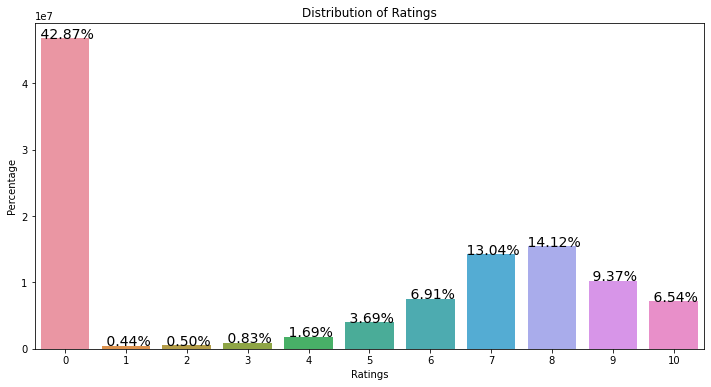

In [6]:
def countplot_with_percentages(serie):
    ax = sns.countplot(serie)
    total_count = serie.count()

    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        percentage = p.get_height() / total_count * 100
        ax.annotate(f'\n{percentage: .2f}%', (x.mean(), y), ha='center', size=14)


plt.figure(figsize=(12, 6))
#plt.axes(yscale="log")

countplot_with_percentages(anime_list.rating)

plt.title("Distribution of Ratings")
plt.ylabel("Percentage")
plt.xlabel("Ratings");

##  Content Based

### Data Processing

In [7]:
anime.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [8]:
anime_df = anime[['MAL_ID', 'Name', 'Score', 'Genres', 'English name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1']].copy()
anime_df.head(2)

,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [9]:
anime_df = anime_df.merge(anime_with_synopsis, how='left', on=['MAL_ID', 'Name', 'Score', 'Genres'])
anime_df.shape

(17562, 35)

In [10]:
anime_df.head(2)

,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,"other day, another bounty—such is the life of ..."


### Data Cleaning and preprocessing

Checking duplicates

In [11]:
anime_df[anime_df.duplicated()==True]

,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,sypnopsis


In [12]:
anime_df.Rating.unique()

array(['R - 17+ (violence & profanity)', 'PG-13 - Teens 13 or older',
       'PG - Children', 'R+ - Mild Nudity', 'G - All Ages', 'Rx - Hentai',
       'Unknown'], dtype=object)

In [13]:
anime_df["Genres"] = anime_df["Genres"].apply(lambda x: x.replace(" ",""))
anime_df["Genres"] = anime_df["Genres"].apply(lambda x: x.replace("-",""))

anime_df["Producers"] = anime_df["Producers"].apply(lambda x: x.replace(" ",""))

anime_df["Licensors"] = anime_df["Licensors"].apply(lambda x: x.replace(" ",""))

anime_df["Studios"] = anime_df["Studios"].apply(lambda x: x.replace(" ",""))

anime_df["Premiered"] = anime_df["Premiered"].apply(lambda x: x.replace(" ",""))

anime_df["Rating"] = anime_df["Rating"].apply(lambda x: re.sub("[^a-zA-Z0-9\n]"," ", x))
anime_df["Rating"] = anime_df["Rating"].apply(lambda x: x.replace(" ",""))

anime_df["sypnopsis"].fillna('', inplace=True)

In [14]:
anime_df.head(2)

,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,sypnopsis
0,1,Cowboy Bebop,8.78,"Action,Adventure,Comedy,Drama,SciFi,Space",Cowboy Bebop,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring1998,BandaiVisual,"Funimation,BandaiEntertainment",Sunrise,Original,24 min. per ep.,R17violenceprofanity,28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action,Drama,Mystery,SciFi,Space",Cowboy Bebop:The Movie,Movie,1,"Sep 1, 2001",Unknown,"Sunrise,BandaiVisual",SonyPicturesEntertainment,Bones,Original,1 hr. 55 min.,R17violenceprofanity,159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,"other day, another bounty—such is the life of ..."


Concatenating all the required textual fields in a single column 

In [15]:
anime_df["tags"] = anime_df["Genres"] + " " + anime_df["Type"] + " " + anime_df["Premiered"] + " " + anime_df["Producers"] + " " + anime_df["Licensors"] + " " + anime_df["Studios"] + " " + anime_df["Source"] + " " + anime_df["Rating"] + " " + anime_df["sypnopsis"]
anime_df.head(2)

,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,sypnopsis,tags
0,1,Cowboy Bebop,8.78,"Action,Adventure,Comedy,Drama,SciFi,Space",Cowboy Bebop,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring1998,BandaiVisual,"Funimation,BandaiEntertainment",Sunrise,Original,24 min. per ep.,R17violenceprofanity,28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,"In the year 2071, humanity has colonized sever...","Action,Adventure,Comedy,Drama,SciFi,Space TV S..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action,Drama,Mystery,SciFi,Space",Cowboy Bebop:The Movie,Movie,1,"Sep 1, 2001",Unknown,"Sunrise,BandaiVisual",SonyPicturesEntertainment,Bones,Original,1 hr. 55 min.,R17violenceprofanity,159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,"other day, another bounty—such is the life of ...","Action,Drama,Mystery,SciFi,Space Movie Unknown..."


In [16]:
anime_df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Type', 'Episodes',
       'Aired', 'Premiered', 'Producers', 'Licensors', 'Studios', 'Source',
       'Duration', 'Rating', 'Ranked', 'Popularity', 'Members', 'Favorites',
       'Watching', 'Completed', 'On-Hold', 'Dropped', 'Plan to Watch',
       'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5',
       'Score-4', 'Score-3', 'Score-2', 'Score-1', 'sypnopsis', 'tags'],
      dtype='object')

In [17]:
anime_data = anime_df[['MAL_ID', 'Name', 'Score', 'English name', 'Episodes',
       'Ranked', 'Popularity', 'Members', 'Favorites',
       'Watching', 'Completed', 'On-Hold', 'Dropped', 'Plan to Watch',
       'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5',
       'Score-4', 'Score-3', 'Score-2', 'Score-1', 'tags']]
anime_data.head(2)

,MAL_ID,Name,Score,English name,Episodes,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,tags
0,1,Cowboy Bebop,8.78,Cowboy Bebop,26,28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,"Action,Adventure,Comedy,Drama,SciFi,Space TV S..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,Cowboy Bebop:The Movie,1,159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,"Action,Drama,Mystery,SciFi,Space Movie Unknown..."


In [18]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'by', 'down', 'to', 'that', 'until', 'herself', 'no', 'against', "hadn't", "needn't", 'once', 'shan', 'before', 'into', 'them', 'further', 'does', 'who', 'all', 'having', 'which', 'when', 'll', 'off', "haven't", 'being', "wouldn't", "should've", 'whom', 'how', 'more', 't', 'me', "you'd", 'with', 'couldn', "mightn't", 'needn', 'am', 'such', 'should', "weren't", 'above', 'if', 'through', 'some', 'very', 'd', "shan't", 'are', 'than', 'what', 'm', 'mightn', 'most', 'has', "shouldn't", 'same', 'haven', 'during', 'each', 've', 'yourselves', 'few', 'nor', 'under', 'mustn', 'won', 'as', 'for', 're', 'we', 'my', 'hers', 'his', "you're", 'they', 'here', 'just', 'between', "that'll", "it's", 'because', 'ours', 'doing', 'had', "doesn't", "wasn't", 'ourselves', 'yours', 'the', 'not', "don't", 'don', "mustn't", 'up', 'our', "won't", 'can', 'too', 'he', 'now', 'in', 'wouldn', 'itself', 'own', 'shouldn', 'after', 'be', 'you', "she's", 'him', 'at', 'isn', 'other', 'did', "you'll", 'her', 'doesn', 'ain

In [21]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anike\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
snow_stemmer = SnowballStemmer(language='english')

In [23]:
#for sentence in tqdm(anime_data["tags"].values):
def text_preprocessing(text):
    text = ' '.join(words.lower() for words in text.split(" ") if words not in stop_words)
    text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
    text = re.sub('\s+',' ', text)
    text = re.sub("\n", " ", text)
    text = re.sub("\t", " ", text)  
    text = re.sub(",", ", ", text)
    text = decontracted(text)
    text = re.sub(r'[^\w\s]', '', text)
    word_list = nltk.word_tokenize(text)
    #text = ' '.join(lemmatizer.lemmatize(word) for word in word_list)
    text = ' '.join(snow_stemmer.stem(word) for word in word_list)
    return text.strip()

In [24]:
anime_data["tags"] = anime_data["tags"].apply(text_preprocessing) 

In [25]:
anime_data.head(2)

,MAL_ID,Name,Score,English name,Episodes,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,tags
0,1,Cowboy Bebop,8.78,Cowboy Bebop,26,28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,action adventur comedi drama scifi space tv sp...
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,Cowboy Bebop:The Movie,1,159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,action drama mysteri scifi space movi unknown ...


In [26]:
anime_data["tags"][0]

'action adventur comedi drama scifi space tv spring1998 bandaivisu funim bandaientertain sunris origin r17violenceprofan in year 2071 human colon sever planet moon solar system leav uninhabit surfac planet earth behind the inter solar system polic attempt keep peac galaxi aid part outlaw bounti hunter refer cowboy the ragtag team aboard spaceship bebop two individu mellow carefre spike spiegel balanc boister pragmat partner jet black pair make live chase bounti collect reward thrown cours addit new member meet travel ein genet engin high intellig welsh corgi femm fatal fay valentin enigmat trickster memori loss strang comput whiz kid edward wong the crew embark thrill adventur unravel member s dark mysteri past littl littl well balanc high densiti action light heart comedi cowboy bebop space western classic homag smooth improvis music name after'

In [27]:
anime_data[anime_data["Score"] == "Unknown"]

,MAL_ID,Name,Score,English name,Episodes,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,tags
1404,1547,Obake no Q-tarou,Unknown,Unknown,96,11270.0,11870,557,0,25,175,26,107,224,8.0,5.0,6.0,20.0,28.0,31.0,6.0,6.0,2.0,10.0,comedi school sliceoflif supernatur tv summer1...
1504,1656,PostPet Momobin,Unknown,Unknown,24,11598.0,12929,359,0,18,140,12,71,118,7.0,2.0,6.0,13.0,17.0,22.0,15.0,12.0,7.0,10.0,comedi kid tv summer2004 unknown unknown unkno...
1578,1739,Shibawanko no Wa no Kokoro,Unknown,Unknown,80,11947.0,11799,574,0,52,104,61,100,257,6.0,4.0,23.0,28.0,18.0,17.0,1.0,3.0,Unknown,8.0,kid tv spring2006 unknown unknown three d unkn...
1699,1863,Silk Road Shounen Yuuto,Unknown,Unknown,26,12096.0,12286,473,0,31,71,8,57,306,3.0,1.0,2.0,9.0,5.0,9.0,3.0,1.0,2.0,3.0,adventur fantasi histor tv fall2006 nhk bs2 un...
1893,2073,Hengen Taima Yakou Karura Mau! Sendai Kokeshi ...,Unknown,Unknown,6,14363.0,11317,693,1,37,158,23,39,436,10.0,3.0,14.0,26.0,27.0,19.0,10.0,3.0,1.0,4.0,horror shoujo ova unknown unknown unknown unkn...
1990,2173,Kouchuu Ouja Mushiking Super Battle Movie: Yam...,Unknown,Mushiking:The King of Beetles SUPER BATTLE MOV...,1,15166.0,12530,424,1,20,159,16,41,188,9.0,5.0,4.0,20.0,22.0,18.0,9.0,3.0,7.0,4.0,adventur fantasi movi unknown sega unknown unk...
2165,2366,Touma Kishinden Oni,Unknown,Unknown,25,12591.0,11179,736,0,56,133,26,66,455,5.0,7.0,16.0,10.0,19.0,18.0,6.0,4.0,2.0,6.0,supernatur tv fall1995 sotsu youmex jinnanstud...
2422,2636,"Dorami-chan: Wow, The Kid Gang of Bandits",Unknown,Unknown,1,13835.0,13232,324,0,14,157,11,34,108,8.0,1.0,7.0,22.0,24.0,21.0,7.0,2.0,1.0,4.0,fantasi movi unknown unknown unknown unknown u...
2425,2639,Dorami-chan: Hello Kyouryuu Kids!!,Unknown,Unknown,1,13844.0,13242,321,0,13,165,9,32,102,6.0,3.0,3.0,23.0,30.0,27.0,8.0,2.0,Unknown,3.0,fantasi movi unknown unknown unknown unknown u...
2428,2642,Dorami-chan: A Blue Straw Hat,Unknown,Unknown,1,13845.0,13790,274,0,10,137,9,29,89,7.0,2.0,4.0,13.0,22.0,26.0,4.0,3.0,2.0,2.0,kid fantasi movi unknown unknown unknown unkno...


In [28]:
anime_data["Score"] = anime_data["Score"].apply(lambda x: re.sub("Unknown","-1", x))

anime_data["Episodes"] = anime_data["Episodes"].apply(lambda x: re.sub("Unknown","-1", x))

anime_data["Ranked"] = anime_data["Ranked"].apply(lambda x: re.sub("Unknown","-1", x))

anime_data["Score-10"] = anime_data["Score-10"].apply(lambda x: re.sub("Unknown","-1", x))

anime_data["Score-9"] = anime_data["Score-9"].apply(lambda x: re.sub("Unknown","-1", x))

anime_data["Score-8"] = anime_data["Score-8"].apply(lambda x: re.sub("Unknown","-1", x))

anime_data["Score-7"] = anime_data["Score-7"].apply(lambda x: re.sub("Unknown","-1", x))

anime_data["Score-6"] = anime_data["Score-6"].apply(lambda x: re.sub("Unknown","-1", x))

anime_data["Score-5"] = anime_data["Score-5"].apply(lambda x: re.sub("Unknown","-1", x))

anime_data["Score-4"] = anime_data["Score-4"].apply(lambda x: re.sub("Unknown","-1", x))

anime_data["Score-3"] = anime_data["Score-3"].apply(lambda x: re.sub("Unknown","-1", x))

anime_data["Score-2"] = anime_data["Score-2"].apply(lambda x: re.sub("Unknown","-1", x))

anime_data["Score-1"] = anime_data["Score-1"].apply(lambda x: re.sub("Unknown","-1", x))

### TF-IDF vectorization

In [29]:
tfidf_vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,3), max_features=5000)
anime_data_tags_tfidf = tfidf_vectorizer.fit_transform(anime_data["tags"]).toarray()

In [30]:
anime_data_tags_tfidf.shape

(17562, 5000)

In [31]:
print(anime_data_tags_tfidf[0])

[0. 0. 0. ... 0. 0. 0.]


In [32]:
print("The top 200 Feature Names are: \n",tfidf_vectorizer.get_feature_names()[0:200])

The top 200 Feature Names are: 
 ['000', '10', '10 year', '100', '10th', '11', '12', '12 year', '12 year old', '13', '13th', '14', '14 year', '14 year old', '15', '15 year', '15 year old', '16', '16 year', '16 year old', '17', '17 year', '17 year old', '18', '19', '1pictur', '1pictur game', '1pictur light', '1pictur light novel', '1pictur manga', '1pictur manga pg13teens13orold', '1pictur origin', '1st', '20', '20 year', '2010', '2011', '2012', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '20th', '21', '21st', '21st centuri', '22', '24', '25', '26', '27', '2nd', '2nd season', '30', '300', '3d', '3rd', '4kidsentertain', '4th', '50', '5th', '6th', '7th', '8bit', 'abandon', 'abcanim', 'abduct', 'abil', 'abl', 'aboard', 'about', 'abrupt', 'absolut', 'abus', 'academi', 'accept', 'accid', 'accident', 'accompani', 'accomplish', 'accord', 'account', 'ace', 'achiev', 'acquaint', 'acquir', 'across', 'act', 'acta', 'action', 'action adventur', 'action adventur comedi', 'action adventur

In [33]:
anime_data["Score"].reshape(-1,1).shape

(17562, 1)

In [34]:
anime_features = pd.concat([anime_data[['Score']].copy(), pd.DataFrame(anime_data_tags_tfidf.tolist())], axis=1)


In [35]:
anime_features.shape

(17562, 5001)

In [36]:
anime_features.head(2)

Score    0    1    2    3    4    5    6    7    8    9   10   11   12   13  \
0  8.78  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  8.39  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    14   15   16   17   18   19   20   21   22   23   24   25   26   27   28  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    29   30   31   32   33   34   35   36   37   38   39   40   41   42   43  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    44   45   46   47   48   49   50   51   52   53   54   55   56   57   58  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    59   60   61   62   63   64   65   66   67   68   69   70   71        72  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.109112   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   

    73   74   75   76   77   78   79   80   81   82   83   84   85   86   87  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    88        89   90   91        92        93        94   95   96   97   98  \
0  0.0  0.000000  0.0  0.0  0.077921  0.060748  0.078445  0.0  0.0  0.0  0.0   
1  0.0  0.093819  0.0  0.0  0.090706  0.000000  0.000000  0.0  0.0  0.0  0.0   

    99  100  101  102  103  104  105  106  107       108  109  110  111  112  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.103839  0.0  0.0  0.0  0.0   

   113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   143  144  145  146       147  148  149  150  151  152  153       154  \
0  0.0  0.0  0.0  0.0  0.095724  0.0  0.0  0.0  0.0  0.0  0.0  0.085007   
1  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   

       155       156  157  158  159  160  161  162  163  164  165  166  167  \
0  0.06241  0.101143  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.00000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   198  199       200  201  202  203  204  205  206  207  208  209  210  211  \
0  0.0  0.0  0.067906  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   212  213  214      215  216  217  218  219  220  221  222  223  224  225  \
0  0.0  0.0  0.0  0.09328  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   226  227  228  229  230  231  232  233  234  235  236  237  238  239  240  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0

In [37]:
scaler = StandardScaler()
anime_features["Score"] = scaler.fit_transform(anime_features["Score"].reshape(-1, 1))

In [38]:
anime_features.head(2)

Score    0    1    2    3    4    5    6    7    8    9   10   11   12  \
0  1.277573  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.166068  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    13   14   15   16   17   18   19   20   21   22   23   24   25   26   27  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    28   29   30   31   32   33   34   35   36   37   38   39   40   41   42  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    43   44   45   46   47   48   49   50   51   52   53   54   55   56   57  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    58   59   60   61   62   63   64   65   66   67   68   69   70   71  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

         72   73   74   75   76   77   78   79   80   81   82   83   84   85  \
0  0.109112  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    86   87   88        89   90   91        92        93        94   95   96  \
0  0.0  0.0  0.0  0.000000  0.0  0.0  0.077921  0.060748  0.078445  0.0  0.0   
1  0.0  0.0  0.0  0.093819  0.0  0.0  0.090706  0.000000  0.000000  0.0  0.0   

    97   98   99  100  101  102  103  104  105  106  107       108  109  110  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.103839  0.0  0.0   

   111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   141  142  143  144  145  146       147  148  149  150  151  152  153  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.095724  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   

        154      155       156  157  158  159  160  161  162  163  164  165  \
0  0.085007  0.06241  0.101143  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.000000  0.00000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   196  197  198  199       200  201  202  203  204  205  206  207  208  209  \
0  0.0  0.0  0.0  0.0  0.067906  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   210  211  212  213  214      215  216  217  218  219  220  221  222  223  \
0  0.0  0.0  0.0  0.0  0.0  0.09328  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   224  225  226  227  228  229  230  231  232  233  234  235  236  237  238  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0

In [39]:
cosine_sim = cosine_similarity(anime_features.values, anime_features.values)

In [40]:
cosine_sim.shape

(17562, 17562)

In [41]:
print(cosine_sim[0])

[ 1.          0.68327943  0.63987852 ... -0.65130579 -0.64619423
 -0.62719443]


In [42]:
anime_index = pd.Series(anime_data.index, index=anime_data.Name)
anime_index.head(2)

Name
Cowboy Bebop                       0
Cowboy Bebop: Tengoku no Tobira    1
dtype: int64

In [43]:
def get_recommendation(anime_name, similarity = cosine_sim):
    index = anime_index[anime_name]
    similarity_scores = sorted(list(enumerate(similarity[index])), reverse=True, key=lambda x:x[1])[0:21]
    anime_indices = [i[0] for i in similarity_scores]
    result = anime[['Name', 'English name', 'Genres']].iloc[anime_indices].drop(index)
    return result

In [44]:
get_recommendation("Naruto")

,Name,English name,Genres
1574,Naruto: Shippuuden,Naruto:Shippuden,"Action, Adventure, Comedy, Super Power, Martia..."
7021,Naruto: Shippuuden Movie 6 - Road to Ninja,Road to Ninja:Naruto the Movie,"Action, Adventure, Super Power, Martial Arts, ..."
6285,Naruto: Shippuuden Movie 5 - Blood Prison,Unknown,"Action, Adventure, Martial Arts, Super Power, ..."
9862,Boruto: Naruto the Movie,Boruto:Naruto the Movie,"Action, Comedy, Martial Arts, Shounen, Super P..."
5304,Naruto: Shippuuden Movie 4 - The Lost Tower,Unknown,"Action, Comedy, Martial Arts, Shounen, Super P..."
2267,Naruto: Shippuuden Movie 1,Naruto:Shippuden the Movie,"Action, Adventure, Comedy, Fantasy, Shounen"
6875,Naruto SD: Rock Lee no Seishun Full-Power Ninden,NARUTO Spin-Off:Rock Lee & His Ninja Pals,"Action, Comedy, Parody"
2058,Naruto: Dai Katsugeki!! Yuki Hime Shinobu Houj...,Hidden Leaf Village Grand Sports Festival,"Action, Comedy, Sports, Martial Arts, Fantasy,..."
6319,Naruto: Honoo no Chuunin Shiken! Naruto vs. Ko...,Chunin Exam on Fire! and Naruto vs. Konohamaru!,"Action, Adventure, Martial Arts, Shounen, Supe..."
3516,"Naruto: Shippuuden - Shippuu! ""Konoha Gakuen"" Den",Naruto Shippuden:Konoha Gakuen - Special,Comedy


In [45]:
get_recommendation("Shingeki no Kyojin")

,Name,English name,Genres
9383,Shingeki no Kyojin Season 2,Attack on Titan Season 2,"Action, Military, Mystery, Super Power, Drama,..."
13252,Shingeki no Kyojin Season 3,Attack on Titan Season 3,"Action, Military, Mystery, Super Power, Drama,..."
15926,Shingeki no Kyojin: The Final Season,Attack on Titan Final Season,"Action, Military, Mystery, Super Power, Drama,..."
14963,Shingeki no Kyojin Season 3 Part 2,Attack on Titan Season 3 Part 2,"Action, Drama, Fantasy, Military, Mystery, Sho..."
13804,Shingeki no Kyojin Season 2 Movie: Kakusei no ...,Unknown,"Action, Drama, Fantasy, Shounen, Super Power"
7879,Shingeki no Kyojin OVA,Unknown,"Action, Super Power, Drama, Fantasy, Shounen"
64,Mobile Suit Zeta Gundam,Mobile Suit Zeta Gundam,"Military, Sci-Fi, Space, Drama, Romance, Mecha"
3971,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma..."
741,Ginga Eiyuu Densetsu,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
2656,Code Geass: Hangyaku no Lelouch R2,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, ..."
